# Titanic dataset exploratory data analysis

*This is a notebook explaining the thought process in performing EDA and data processing. A presentation to a non programmer would not include the code parts unless requested.*

Importing the necessary modules and setting the seaborn plotting theme.  
**titanicTransformers** module contains the classes and functions that were defined for transforming the data, as explained later.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from titanicTransformers import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

sns.set_theme()
sns.set_style('white')

Reading the dataset in the raw form, as provided by Kaggle.

In [26]:
raw = pd.read_csv(r'/home/panos/Python/MachineLearning/titanic/datasets/titanic.csv')
raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Features explained:

* PassengerID: Each passenger's identification number.
* Survived: 1=Yes, 0=No. This is the variable which will be predicted by the classification models later.
* Pclass: Passenger class 1st, 2nd or 3d.
* Name: Full name of each passenger, including title.
* Sex: Sex of each passenger.
* Age: Age of each passenger.
* SibSp: Number of sibling and /or spouses on board.
* Parch: Number of parents and/or children on board.
* Ticket: The ticket number.
* Fare: The ticket's cost.
* Cabin: Cabin's number if there was one assigned. Otherwise listed as empty.
* Embarked: The embarkation port, S for Southampton, C for Cherbourg, Q for Queenstown.


In [27]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As observed above, there are both numerical (int64, float) and strings (object) variables.  
There are also missing values in the Age, Cabin and Embarked variables, that are going to be dealt with later.  

## Investigating Correlation between numeric variables

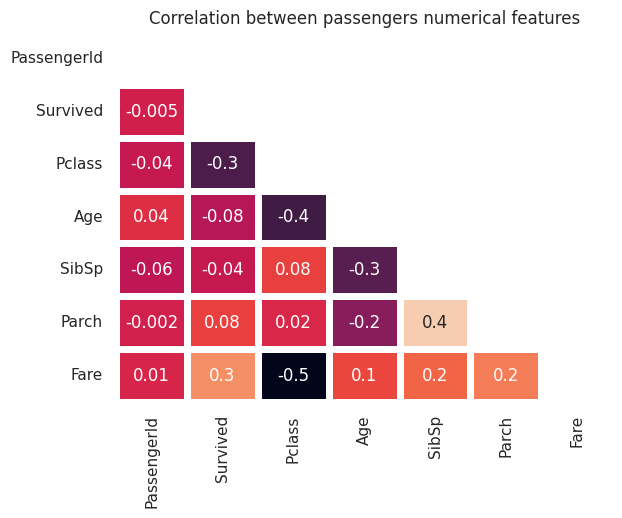

In [28]:
corrMatrix = raw.corr(numeric_only=True)
corrMask = np.triu(np.ones_like(corrMatrix))

sns.heatmap(corrMatrix, annot=True, fmt=".1g", linewidths=5, mask=corrMask, vmax=0.5, cbar=False)
plt.title("Correlation between passengers numerical features", fontsize=12)
plt.show()

As observed in the correlation matrix above, there is positive correlation between **Passenger Class** and **Fare**, as expected.

There is notable negative correlation between **Survival** rate and **Passenger Class**. Meaning that the casualties were less for higher, more expensive classes. (Though a high class means lower in numeric value, as 1 is lower than 3, that is why the negative sign)  

Finally, negative correlation exists between **Passenger Class** and **Age**, meaning more older individuals bought 1st and 2nd class tickets.

## Train-test split

Next, the dataset is being divided first to X (independent) and y (dependent) variables, before splitting them to the **train** and **test sets**.  
The train-test split is done by stratifying based on the **passenger class** variable, to ensure that the proportion of different classes remains consistent in both the training and testing sets.

In [29]:
X = raw.drop(columns='Survived')
y = raw['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=raw['Pclass'] )

For readability purposes, a new column called *Survival* is created, as a direct mapping to the *Survived* column, but containing 'Yes' or 'No' instead of binary values. 

In [30]:
titanic = raw.iloc[X_train.index, :].copy()
titanic.rename(columns={'Survived':'Survival'}, inplace=True)
titanic['Survived'] = titanic['Survival'].replace([0,1], ['No', 'Yes'])

## Survival depending on the sex and age of passengers

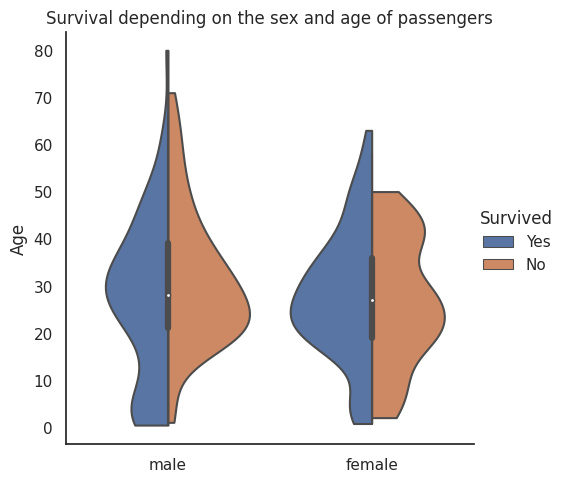

In [31]:
sns.catplot(data=titanic, x="Sex", y="Age", hue='Survived', kind="violin", hue_order=['Yes','No'], bw=0.35, cut=0, split=True).set(xlabel=None)
plt.title("Survival depending on the sex and age of passengers")
plt.show()

In the above plot the number of passengers is indicated by the thickness of the area, while the age is indicated by the height. Blue color for survivors and orange for deceased.  
  
  
As we can see, the key takeaway is that **female children** did not fare well, while the opposite is true for **male children**.  

## Survival depending on passenger class

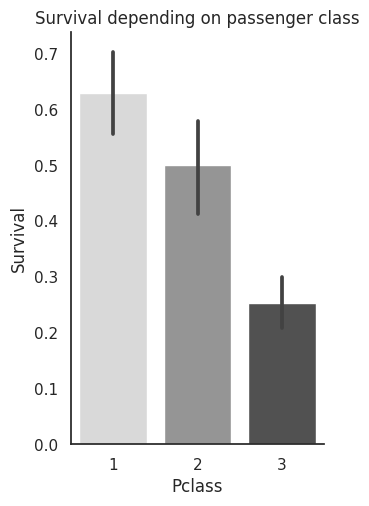

In [32]:
sns.catplot(kind='bar', data=titanic, x='Pclass', y='Survival', aspect=0.7, palette="Greys")
plt.title("Survival depending on passenger class")
plt.show()

As recorded during the correlation investigation, the survival rate **drops** dramatically for the lower classes, especially the 3d, with a rate of 25%.

## Data processing  
Data has to be processed before it can be fed to machine learning models. Features like passenger ID, ticket number or passenger name offered no valuable insights so they were removed.  

Due to potential **data snooping bias**, only the train set is being explored.


### Feature transformation
Embarkation ports and passengers' sex were transformed to binary values using the *one hot encoding* method and direct mapping respectively.  

An assumption was made for the Cabin variable, where no cabin listed means no cabin was provided. This assumption can be tested as accurate or not during the model tuning process.  


### Missing values imputation
Missing values for each variable were filled with its mean value.  
After the Cabin assumption, only the **Age** variable still carried missing values. So more sophisticated imputation methods like the KNN imputer were not deemed necessary.

### Scaling
Data scaling before modeling is necessary to ensure that all features are on a similar scale and have comparable importance.

### Transformation pipeline
All of the above were combined into a single transformation function that can be explored in the **titanicTransformers module**.  

Each transformer, Encoder, Imputer and Scaler, can be used in synergy with sklearn.pipeline module for ease of implementation.

In [33]:
Xtransformed = transformTitanicDf(X_train)
Xtransformed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
0,1.0,0.0,0.258608,0.000,0.0,0.015216,0.0,0.0,0.0,1.0
1,1.0,0.0,0.364142,0.000,0.0,0.014110,0.0,1.0,0.0,0.0
2,0.0,1.0,0.364142,0.125,0.0,0.260867,0.0,0.0,0.0,1.0
3,1.0,0.0,0.334004,0.000,0.0,0.015412,0.0,0.0,0.0,1.0
4,0.0,0.0,0.334004,0.125,0.0,0.103644,1.0,0.0,0.0,1.0


### Histogram of each feature after data transformation

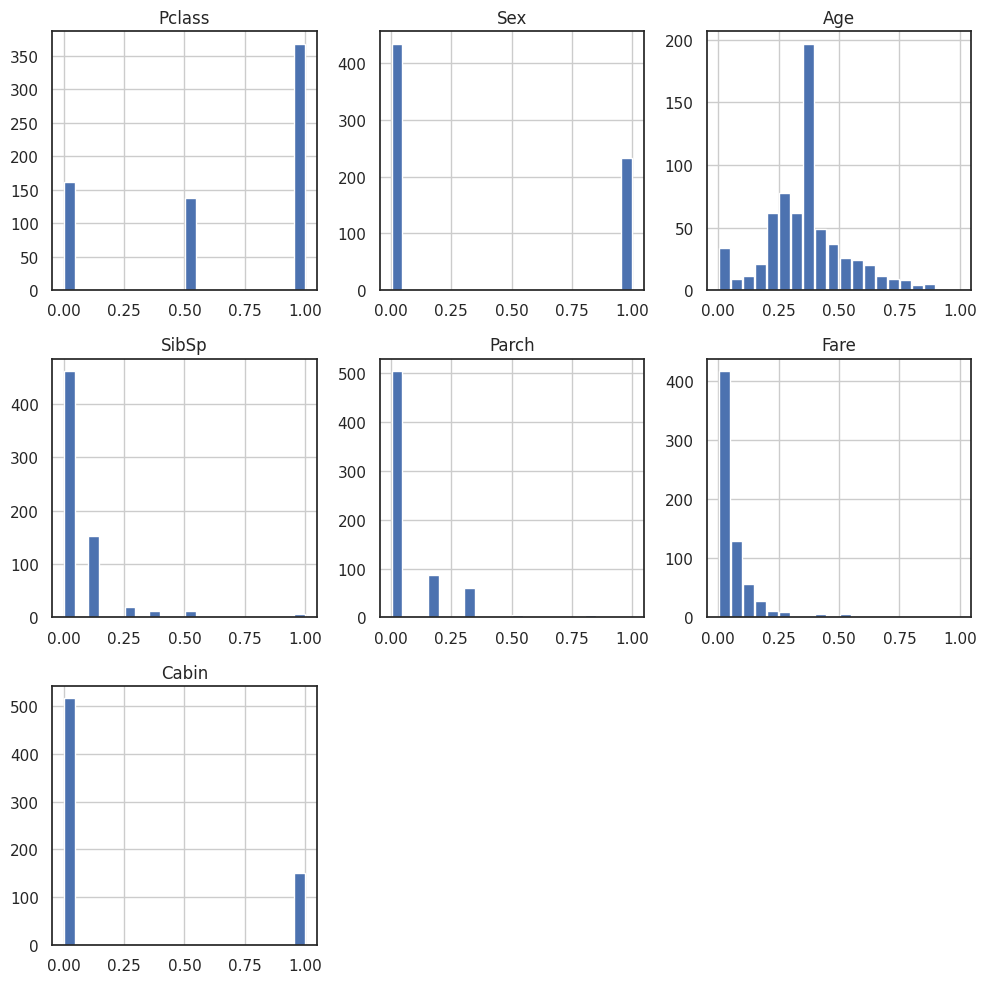

In [36]:
Xtransformed.iloc[:,:-3].hist(bins=20, figsize=(10,10), rwidth=0.9, zorder=2)
plt.tight_layout()
plt.title()
plt.show()

### Saving datasets for modelling

In [ ]:
Xtransformed.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\titanicTransformed.csv', index=False)
X_train.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\X_train.csv', index=False)
X_test.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\X_test.csv', index=False)
y_train.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\y_train.csv', index=False)
y_test.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\y_test.csv', index=False)
